<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/finetune_cnn_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Fine-tuning a resnet image classifier to classify hotdog vs not-hotdog

We illustrate how to fine-tune a resnet classifier which has been pre-trained on ImageNet. 
Based on sec 13.2 of 
http://d2l.ai/chapter_computer-vision/fine-tuning.html.
The target dataset consists of 2 classes (hotdog vs no hotdog), and has 1400 images of each. (This example is inspired by [Season 4, Episode 4 of the TV show Silicon Valley](https://www.youtube.com/watch?v=ACmydtFDTGs).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math
import os

import torch
from torch import nn
from torch.nn import functional as F
import torchvision

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l

mkdir: cannot create directory ‘figures’: File exists


# Dataset

In [ ]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                          'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

In [ ]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

We show the first 8 positive and last 8 negative images. We see the aspect ratio is quite different.

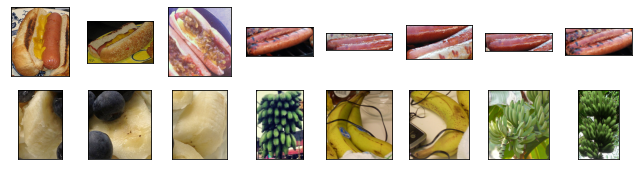

In [ ]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

We use data augmentation at train and test time, as shown below.


In [ ]:
# We specify the mean and variance of the three RGB channels to normalize the
# image channel
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(), normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(), normalize])

# Model

In [ ]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


The final layer is called `fc`, for fully connected.

In [10]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[-0.0063, -0.0682,  0.0907,  ...,  0.0809, -0.0432, -0.0265],
        [ 0.0257,  0.0142, -0.0968,  ..., -0.0086,  0.0570,  0.0939]],
       requires_grad=True)

# Fine tuning

In D2L, they call their training routine `train_ch13`, since it is in their chapter 13. We modify their code so it uses a single GPU, by commenting out the `DataParallel` part.

In [16]:
def train_batch(net, X, y, loss, trainer, devices):
    X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum


def train(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    #net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    net = net.to(devices[0])
    for epoch in range(num_epochs):
        # Store training_loss, training_accuracy, num_examples, num_features
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(net, features, labels, loss, trainer,
                                      devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

We update all the parameters, but use a 10x larger learning rate for the fc layer.

In [12]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                         transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'),
                                         transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [
            param for name, param in net.named_parameters()
            if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([
          {'params': params_1x}, 
            {'params': net.fc.parameters(),'lr': learning_rate * 10}
                ],
                 lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    train(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

loss 0.251, train acc 0.910, test acc 0.929
1063.0 examples/sec on [device(type='cuda', index=0)]


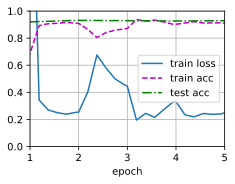

In [17]:
train_fine_tuning(finetune_net, 5e-5)

# Test the model

In [22]:
net = finetune_net.to('cpu')
net.eval(); # set to eval mode (not training)

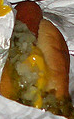

In [19]:
fname = os.path.join(data_dir, 'test', 'hotdog', '1000.png')
from PIL import Image
img = Image.open(fname)
display(img)


In [24]:
img_t = test_augs(img) # convert to tensor
batch_t = torch.unsqueeze(img_t, 0)
out = net(batch_t)
probs = F.softmax(out,dim=1)
print(probs)

tensor([[0.9769, 0.0231]], grad_fn=<SoftmaxBackward>)


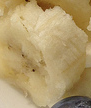

In [25]:
fname = os.path.join(data_dir, 'test', 'not-hotdog', '1000.png')
from PIL import Image
img = Image.open(fname)
display(img)


In [26]:
img_t = test_augs(img) # convert to tensor
batch_t = torch.unsqueeze(img_t, 0)
out = net(batch_t)
probs = F.softmax(out,dim=1)
print(probs)

tensor([[0.0022, 0.9978]], grad_fn=<SoftmaxBackward>)
